In [1]:
from minio import Minio
from dotenv import load_dotenv
import os
import json
import pandas as pd

In [2]:
load_dotenv()

minio_client = Minio(
    endpoint=os.getenv("MINIO_ENDPOINT"),
    access_key=os.getenv("MINIO_ACCESS_KEY"), 
    secret_key=os.getenv("MINIO_SECRET_KEY"), 
    secure=False 
)
bucket_name = os.getenv("MINIO_BUCKET_NAME")
pasta_prefix = "Portalnoticiasceara/noticias_recentes_ultimo_mes" 

In [3]:
list_objects = minio_client.list_objects(bucket_name, prefix=pasta_prefix, recursive=True)

In [4]:
objetos = [minio_client.get_object(bucket_name=bucket_name, object_name=obj.object_name) for obj in list_objects if obj.object_name.endswith('metadata.json')]

In [5]:
dataframes = []
for response in objetos:
    data = response.read().decode('utf-8')
    
    json_data = json.loads(data)
    df = pd.json_normalize(json_data)
    dataframes.append(df)  
final_dataframe = pd.concat(dataframes, ignore_index=True)  

In [6]:
final_dataframe.head()

,id,mensagem,data,media_path,faccao,bairro
0,6680,Homicídio a bala registrado neste domingo (29)...,2024-12-29 14:04:04,[],None,jardim_das_oliveiras
1,6691,**Polícia militar age rápido e apreende acusad...,2024-12-29 16:53:10,[],None,edson_queiroz
2,6665,"**Duplo Homicídio no Bairro Aracapé, em Fortal...",2024-12-29 09:59:53,[],GDE,planalto_ayrton_senna
3,6668,**Acidente registrado há poucos minutos na Bar...,2024-12-29 10:25:12,[],None,barra_do_ceara
4,6700,CHOQUE COM POSTE COM VITIMA FATAL - RUA DEMET...,2024-12-29 18:09:19,[],None,antonio_bezerra


In [ ]:
final_dataframe.shape[0]

361

In [ ]:
final_dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
id,361.0,5996.116343,537.239051,5074.0,5512.0,5962.0,6442.0,6957.0


In [ ]:
len(final_dataframe[final_dataframe['faccao'] == 'GDE'])

45

In [ ]:
len(final_dataframe[final_dataframe['faccao'] == 'CV'])

70

In [11]:
len(final_dataframe[final_dataframe['faccao'] == 'TDN'])

29

In [12]:
len(final_dataframe[final_dataframe['faccao'] == 'PCC'])

2

In [13]:
len(final_dataframe[final_dataframe['faccao'] == 'MASSA'])

0

In [14]:
df_one_hot = pd.get_dummies(final_dataframe[['mensagem', 'faccao']], columns=['faccao'])

In [15]:
df_one_hot.head()

,mensagem,faccao_CV,faccao_GDE,faccao_PCC,faccao_TDN
0,Homicídio a bala registrado neste domingo (29)...,False,False,False,False
1,**Polícia militar age rápido e apreende acusad...,False,False,False,False
2,"**Duplo Homicídio no Bairro Aracapé, em Fortal...",False,True,False,False
3,**Acidente registrado há poucos minutos na Bar...,False,False,False,False
4,CHOQUE COM POSTE COM VITIMA FATAL - RUA DEMET...,False,False,False,False


In [ ]:
df_filtered = df_one_hot[(df_one_hot[['faccao_CV', 'faccao_GDE', 'faccao_TDN', 'faccao_PCC']].sum(axis=1) > 0)]

##### Anotações
- Remoção de Pontuação e Caracteres Especiais:
    Remover caracteres especiais e pontuação que não são importantes para o modelo.
- Lowercasing:
    Converter o texto para minúsculas para evitar duplicação devido à diferença de maiúsculas/minúsculas.
- Tokenização:
    Dividir o texto em palavras ou tokens.
- Remoção de Stop Words:
    Eliminar palavras comuns, como "a", "e", "o", que não trazem valor informativo.
- Lematização ou Stemming:
    Reduzir palavras a suas formas base (ex: "correr" e "correu" para "correr").

In [17]:
# !pip install scikit-learn nltk

In [18]:
import string

stopwords_pt = ['a', 'o', 'e', 'é', 'de', 'em', 'que', 'para', 'com', 'um', 'na', 'no', 'se', 'os', 'as']
def preprocess_text_alternativo(text):

    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_pt]
    tokens = [t for t in tokens] 
    return ' '.join(tokens)


df_filtered['mensagem'] = df_filtered['mensagem'].apply(preprocess_text_alternativo)


/tmp/ipykernel_1117/4186501716.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mensagem'] = df_filtered['mensagem'].apply(preprocess_text_alternativo)


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df_filtered['mensagem'])  


In [20]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3547 stored elements and shape (146, 869)>

In [21]:
vectorizer

TfidfVectorizer(max_features=5000)

In [22]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, df_filtered[['faccao_CV', 'faccao_GDE', 'faccao_TDN', 'faccao_PCC']], test_size=0.2, random_state=42)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier


lr = LogisticRegression(max_iter=1000)
model = MultiOutputClassifier(lr)

model.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [24]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_samples = f1_score(y_test, y_pred, average='samples')

print("F1 Weighted:", f1_weighted)
print("F1 Samples:", f1_samples)
print("F1 Micro:", f1_micro)
print("F1 Macro:", f1_macro)


F1 Weighted: 0.5490196078431372
F1 Samples: 0.4666666666666667
F1 Micro: 0.6363636363636364
F1 Macro: 0.20588235294117646


/home/nycolasdiaas/Projetos/zarea-de-risco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nycolasdiaas/Projetos/zarea-de-risco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)

Acurácia: 0.4666666666666667


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_test, y_pred, average=None)  
recall = recall_score(y_test, y_pred, average=None)  
f1 = f1_score(y_test, y_pred, average=None)  

print("Precisão por classe:", precision)
print("Recall por classe:", recall)
print("F1 por classe:", f1)

Precisão por classe: [1. 0. 0. 0.]
Recall por classe: [0.7 0.  0.  0. ]
F1 por classe: [0.82352941 0.         0.         0.        ]


/home/nycolasdiaas/Projetos/zarea-de-risco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nycolasdiaas/Projetos/zarea-de-risco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nycolasdiaas/Projetos/zarea-de-risco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, y_pred, average='micro', multi_class='ovr')  # 'ovr' para One-vs-Rest
print("AUC:", roc_auc)


AUC: 0.7333333333333334


In [28]:
# !pip install seaborn matplotlib

Matriz de Confusão para a classe: faccao_CV
[[10  0]
 [ 6 14]]


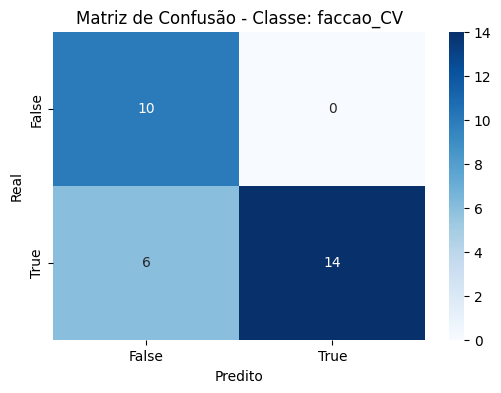

Matriz de Confusão para a classe: faccao_GDE
[[25  0]
 [ 5  0]]


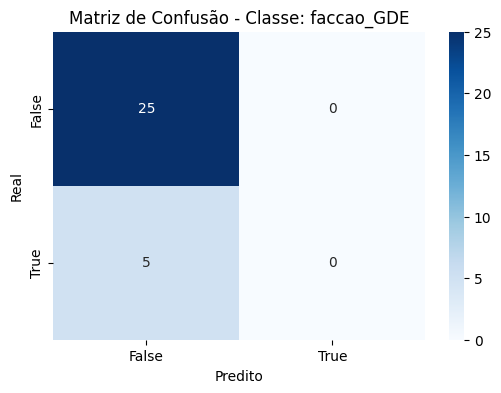

Matriz de Confusão para a classe: faccao_TDN
[[25  0]
 [ 5  0]]


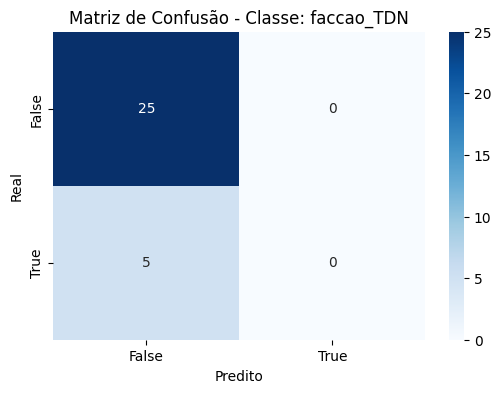

Matriz de Confusão para a classe: faccao_PCC
[[30]]


/home/nycolasdiaas/Projetos/zarea-de-risco/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


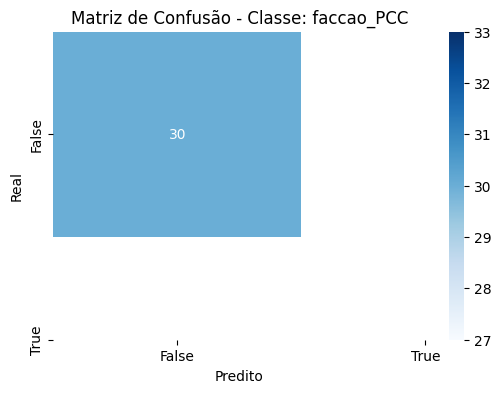

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


for i, column in enumerate(y_test.columns):
    print(f'Matriz de Confusão para a classe: {column}')
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['False', 'True'], yticklabels=['False', 'True'])
    plt.title(f'Matriz de Confusão - Classe: {column}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
